In [4]:
import pandas as pd
from glob import glob
from tqdm import tnrange, tqdm_notebook

## Load Datasets

In [5]:
path = '/Users/ridleyleisy/Documents/lambda/unit_two/DS-Unit-2-Classification-2/'

In [6]:
current = pd.read_csv(path + 'data/primaryMarketNotes_browseNotes_1-RETAIL.csv')

In [7]:
df = pd.read_csv(path + '/master_df.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (20,56,113,124,125,126,129,130,131,134,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,7,NaN,NaN,10000.0,10000.0,10000.0,60 months,12.40%,224.48,B,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,51,NaN,NaN,15000.0,15000.0,15000.0,60 months,17.97%,380.66,D,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,80,NaN,NaN,35000.0,35000.0,35000.0,60 months,13.08%,797.80,B,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,135,NaN,NaN,17500.0,17500.0,17500.0,36 months,17.19%,625.58,C,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,146,NaN,NaN,13750.0,13750.0,13750.0,36 months,28.80%,574.71,D,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## Split Data

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
historical, _ = train_test_split(df.copy(), train_size=0.20, 
                             stratify=df['loan_status'])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
common_columns = set(historical.columns) & set(current.columns)
just_historical = set(historical.columns) - set(current.columns)
just_current = set(current.columns) - set(historical.columns)

## Wrangle

In [12]:
historical[common_columns].describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
initial_list_status,256668,2,w,155882
term,256668,2,36 months,206392
application_type,256668,2,Individual,251178
grade,256668,4,B,83337
home_ownership,256668,6,MORTGAGE,128517
emp_length,241168,11,10+ years,84249
purpose,256668,14,debt_consolidation,146590
sub_grade,256668,20,C1,17828
addr_state,256668,50,CA,37423
int_rate,256668,405,10.99%,7670


In [13]:
def string_split_cols(df):
    # remove xx from zip code and change to numeric
    df['zip_code'] = pd.to_numeric(df['zip_code'].str.strip('xx'))
    
    # convert emp length to numeric after string splits
    df['emp_length'] = df['emp_length'].str.strip(' years').str.strip('< ').str.strip('+')
    df['emp_length'] = pd.to_numeric(df['emp_length'].fillna(0))
    
    # convert revol and int rate to numeric
    df['revol_util'] = pd.to_numeric(df['revol_util'].str.strip('%')) / 100
    df['int_rate'] = pd.to_numeric(df['int_rate'].str.strip('%')) / 100
    
    return df

In [14]:
def clean_date_cols(df):
    df[['sec_app_earliest_cr_line_month','sec_app_earliest_cr_line_year']] = df['sec_app_earliest_cr_line'].str.split('-',expand=True).fillna(0)
    df[['earliest_cr_line_month','earliest_cr_line_year']] = df['earliest_cr_line'].str.split('-',expand=True).fillna(0)
    
    # year to numeric
    df['sec_app_earliest_cr_line_year'] = pd.to_numeric(df['sec_app_earliest_cr_line_year'])
    df['earliest_cr_line_year'] = pd.to_numeric(df['earliest_cr_line_year'])
    
    df = df.drop('sec_app_earliest_cr_line',axis=1)
    df = df.drop('earliest_cr_line',axis=1)
    return df

In [15]:
historical = clean_date_cols(historical)

In [16]:
historical = string_split_cols(historical)

### Many Nulls

In [17]:
def null_drop_cols(df:pd.DataFrame, threshold=0.5) -> list:
    
    df_nulls = df.isnull().sum() #storing summed null df in dataframe
    
    drop_condition = (df_nulls == df.shape[0]) # cols that contain all null values
    null_condition = ((df_nulls > (threshold * df.shape[0])) & # cols that contain nulls values above threshold 
            (df_nulls < df.shape[0]))
    
    drop_cols = list(df_nulls[drop_condition].index) # storing drop cols
    null_cols = list(df_nulls[null_condition].index) # storing null cols
    
    return null_cols, drop_cols

In [18]:
null_cols, drop_cols = null_drop_cols(historical)

In [45]:
def transform_null_drop(df:pd.DataFrame, null_cols:list, drop_cols:list):
        
    for col in drop_cols:
        df = df.drop(col,axis=1)
    
    # For features with few nulls, do mean imputation
    for col in null_cols:
        if df[col].dtype == 'O':
            df = df.drop(col, axis=1)
        elif df[col].dtype == 'float':
            df[col] = df[col].fillna(df[col].mean())
    
    df = df.fillna(0)
    return df

In [46]:
historical = transform_null_drop(historical, null_cols, drop_cols)

## Define Target and Features

In [47]:
target = 'loan_status'
features = list(historical.columns)

In [48]:
desc = historical[features].describe(exclude='number').T.sort_values(by='unique')

In [49]:
hot_encode_cols = list(desc[desc['unique'] <= 80].index)

In [50]:
ord_encode_cols = list(desc[desc['unique'] > 80].index)

In [51]:
desc

,count,unique,top,freq
hardship_flag,256668,1,N,256668
pymnt_plan,256668,1,n,256668
term,256668,2,36 months,206392
debt_settlement_flag,256668,2,N,250886
application_type,256668,2,Individual,251178
loan_status,256668,2,Fully Paid,211715
initial_list_status,256668,2,w,155882
verification_status,256668,3,Source Verified,99868
grade,256668,4,B,83337
home_ownership,256668,6,MORTGAGE,128517


## Baseline Model

### Train/Val/Test Split

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
X = historical[features]
y = historical[target]

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, stratify=historical['loan_status'])

In [ ]:
X_trainval.shape, X_test.shape

In [ ]:
y_trainval.values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval.values)

In [ ]:
# check shapes add up 
X_train.shape, X_val.shape, X_test.shape

In [ ]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0], historical.shape[0]

### Training

In [ ]:
X_train.isna().sum()

In [34]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [38]:
pipeline = make_pipeline(ce.OneHotEncoder(cols=hot_encode_cols),
                         ce.OrdinalEncoder(cols=ord_encode_cols),
                         LogisticRegression())

In [41]:
pipeline.fit(X_train,y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [66]:
pipeline.score(X_val,y_val)

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [ ]:
pipeline.score(X_train, y_train)

## Confusion Matrix

In [251]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns

In [252]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

In [253]:
y_pred = pipeline.predict(X_val)

In [254]:
y_pred

array(['Fully Paid', 'Fully Paid', 'Fully Paid', ..., 'Fully Paid',
       'Fully Paid', 'Fully Paid'], dtype=object)

In [255]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

 Charged Off       0.45      0.00      0.01      8429
  Fully Paid       0.83      1.00      0.90     39697

   micro avg       0.82      0.82      0.82     48126
   macro avg       0.64      0.50      0.45     48126
weighted avg       0.76      0.82      0.75     48126



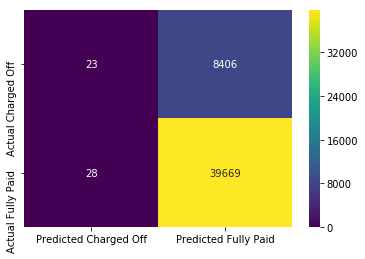

In [256]:
plot_confusion_matrix(y_val,y_pred)

### ROC

In [258]:
y_val_prob = pipeline.predict_proba(X_val)

In [261]:
y_val_prob[:,1]

array([0.91087203, 0.78691737, 0.77882526, ..., 0.83627501, 0.83266318,
       0.95157056])

In [262]:
roc_auc_score(y_val,y_val_prob[:,1])

0.6490129960694997

In [264]:
historical.columns

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       ...
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term',
       'sec_app_earliest_cr_line_month', 'sec_app_earliest_cr_line_year',
       'earliest_cr_line_month', 'earliest_cr_line_year'],
      dtype='object', length=149)